In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-07-16 02:53:21,349: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-07-16 02:53:21,402: INFO: common: yaml file: params.yaml loaded successfully]
[2024-07-16 02:53:21,412: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-07-16 02:53:21,416: INFO: common: created directory at: artifacts]
[2024-07-16 02:53:21,419: INFO: common: created directory at: artifacts/model_trainer]
[2024-07-16 02:53:21,488: INFO: 1869988456: Training ridge...]
[2024-07-16 02:53:21,548: INFO: 1869988456: ridge - MAE: 0.1334]
[2024-07-16 02:53:21,550: INFO: 1869988456: Training elasticnet...]
[2024-07-16 02:53:21,613: INFO: 1869988456: elasticnet - MAE: 0.1073]
[2024-07-16 02:53:21,615: INFO: 1869988456: Training bayesian_ridge...]
[2024-07-16 02:53:21,673: INFO: 1869988456: bayesian_ridge - MAE: 0.0939]
[2024-07-16 02:53:21,676: INFO: 1869988456: Training huber_regressor...]
[2024-07-16 02:53:24,265: INFO: 1869988456: huber_regressor - MAE: 0.0641]
[2024-07-16 02:53:24,

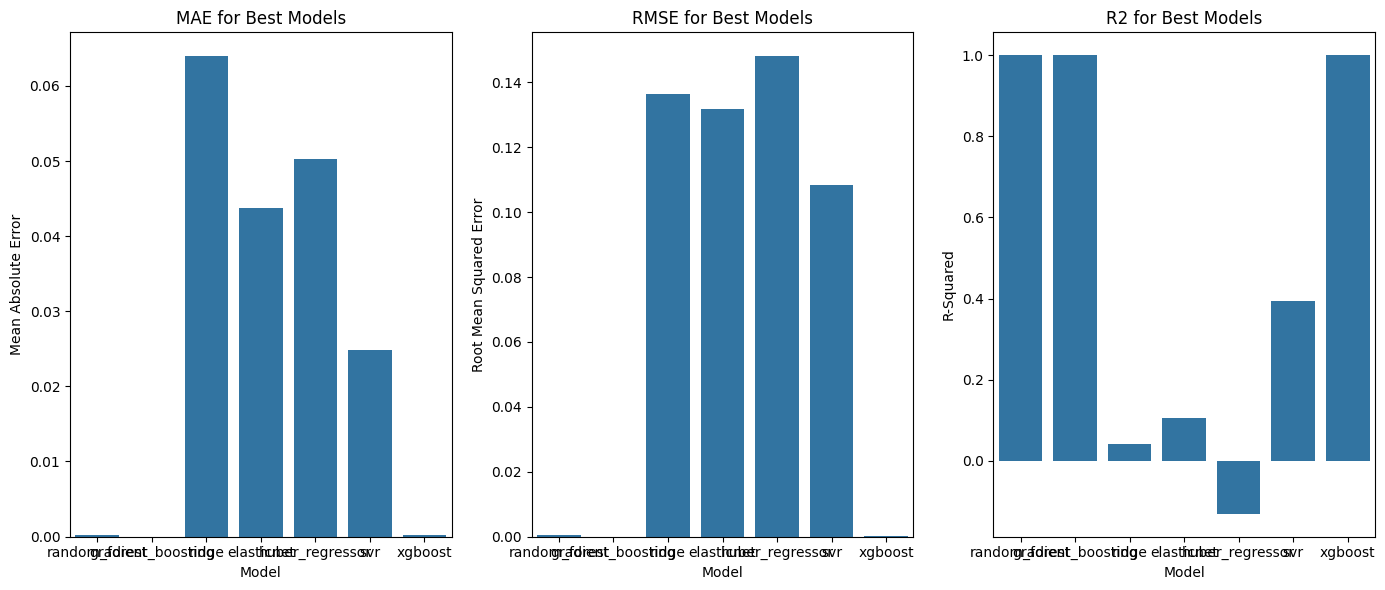

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from dataclasses import dataclass
from pathlib import Path
from Dental_Implant_Sandblasting import logger
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Define ModelTrainerConfig dataclass
@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    test_size: float
    random_state: int
    models: dict
    param_grids: dict
    alpha: float
    l1_ratio: float
    target_column: str
    cv: int
    scoring: str

# Define ConfigurationManager class
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH, schema_filepath=SCHEMA_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        create_directories([self.config['artifacts_root']])

    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config['model_trainer']
        params = self.params['model_training']
        param_grids = self.params['hyperparameter_tuning']

        create_directories([config['root_dir']])

        try:
            alpha = params['models']['elasticnet']['alpha']
            l1_ratio = params['models']['elasticnet']['l1_ratio']
        except KeyError as e:
            logger.error(f"KeyError: {e} - Check the params.yaml file for the correct structure.")
            raise

        target_column = params['target_column']

        def convert_to_dict(d):
            return {k: list(v) if isinstance(v, (list, tuple)) else v for k, v in d.items()}

        model_trainer_config = ModelTrainerConfig(
            root_dir=Path(config['root_dir']),
            train_data_path=Path(config['train_data_path']),
            test_data_path=Path(config['test_data_path']),
            test_size=params['test_size'],
            random_state=params['random_state'],
            models=params['models'],
            param_grids={key: convert_to_dict(value['param_grid']) for key, value in param_grids.items() if isinstance(value, dict) and 'param_grid' in value},
            alpha=alpha,
            l1_ratio=l1_ratio,
            target_column=target_column,
            cv=param_grids['cv'],
            scoring=param_grids['scoring']
        )
        return model_trainer_config

# Define ModelTrainer class
class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config
        self.models = {
            "ridge": Ridge(alpha=self.config.models['ridge']['alpha']),
            "elasticnet": ElasticNet(alpha=self.config.alpha, l1_ratio=self.config.l1_ratio),
            "bayesian_ridge": BayesianRidge(),
            "huber_regressor": HuberRegressor(epsilon=self.config.models['huber_regressor']['epsilon'], max_iter=self.config.models['huber_regressor']['max_iter']),
            "random_forest": RandomForestRegressor(random_state=self.config.random_state),
            "gradient_boosting": GradientBoostingRegressor(random_state=self.config.random_state),
            "svr": SVR(),
            "xgboost": XGBRegressor(random_state=self.config.random_state)
        }
        self.param_grids = self.config.param_grids

    def load_data(self):
        try:
            train_data = pd.read_csv(self.config.train_data_path)
            test_data = pd.read_csv(self.config.test_data_path)

            X_train = train_data.drop(columns=[self.config.target_column])
            y_train = train_data[self.config.target_column]

            X_test = test_data.drop(columns=[self.config.target_column])
            y_test = test_data[self.config.target_column]

            return X_train, y_train, X_test, y_test
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise

    def preprocess_data(self, X_train, y_train, X_test, y_test):
        try:
            # Impute missing values in features
            imputer = SimpleImputer(strategy='mean')
            X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

            # Impute missing values in target
            y_imputer = SimpleImputer(strategy='mean')
            y_train = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
            y_test = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()

            return X_train, y_train, X_test, y_test
        except Exception as e:
            logger.error(f"Error preprocessing data: {e}")
            raise

    def evaluate_models(self, X_train, y_train):
        model_performance = {}

        for model_name, model in self.models.items():
            logger.info(f"Training {model_name}...")
            try:
                cv_scores = cross_val_score(model, X_train, y_train, cv=self.config.cv, scoring=self.config.scoring)
                mae = -cv_scores.mean()

                model_performance[model_name] = {
                    "MAE": mae
                }

                logger.info(f"{model_name} - MAE: {mae:.4f}")
            except Exception as e:
                logger.error(f"Error training {model_name}: {e}")

        return model_performance

    def hyperparameter_tuning(self, X_train, y_train):
        best_models = {}

        for model_name in self.param_grids.keys():
            grid_search = GridSearchCV(
                estimator=self.models[model_name],
                param_grid=self.param_grids[model_name],
                cv=self.config.cv,
                scoring=self.config.scoring,
                n_jobs=-1,
                verbose=2
            )
            logger.info(f"Tuning {model_name}...")
            try:
                grid_search.fit(X_train, y_train)
                best_models[model_name] = grid_search.best_estimator_
                logger.info(f"Best parameters for {model_name}: {grid_search.best_params_}")
            except Exception as e:
                logger.error(f"Error tuning {model_name}: {e}")

        return best_models

    def evaluate_best_models(self, best_models, X_test, y_test):
        performance_metrics = {}

        for model_name, model in best_models.items():
            try:
                y_pred = model.predict(X_test)
                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)

                performance_metrics[model_name] = {
                    "MAE": mae,
                    "RMSE": rmse,
                    "R2": r2
                }

                logger.info(f"{model_name} - Test MAE: {mae:.4f}")
                logger.info(f"{model_name} - Test RMSE: {rmse:.4f}")
                logger.info(f"{model_name} - Test R2: {r2:.4f}")
            except Exception as e:
                logger.error(f"Error evaluating {model_name}: {e}")

        return performance_metrics

    def save_best_models(self, best_models):
        for model_name, model in best_models.items():
            try:
                joblib.dump(model, self.config.root_dir / f"{model_name}.joblib")
                logger.info(f"Saved best model {model_name} to {self.config.root_dir / f'{model_name}.joblib'}")
            except Exception as e:
                logger.error(f"Error saving model {model_name}: {e}")

    def execute(self):
        try:
            X_train, y_train, X_test, y_test = self.load_data()
            X_train, y_train, X_test, y_test = self.preprocess_data(X_train, y_train, X_test, y_test)
            model_performance = self.evaluate_models(X_train, y_train)
            performance_df = pd.DataFrame(model_performance).T
            print("\nModel Performance:\n", performance_df)

            best_models = self.hyperparameter_tuning(X_train, y_train)
            performance_metrics = self.evaluate_best_models(best_models, X_test, y_test)

            best_hyperparameters = {model_name: model.get_params() for model_name, model in best_models.items()}
            print("\nBest Hyperparameters:\n", best_hyperparameters)
            print("\nPerformance Metrics:\n", performance_metrics)

            self.save_best_models(best_models)

            # Visualizations
            metrics_df = pd.DataFrame(performance_metrics).T

            plt.figure(figsize=(14, 6))
            plt.subplot(1, 3, 1)
            sns.barplot(x=metrics_df.index, y=metrics_df['MAE'])
            plt.title('MAE for Best Models')
            plt.ylabel('Mean Absolute Error')
            plt.xlabel('Model')

            plt.subplot(1, 3, 2)
            sns.barplot(x=metrics_df.index, y=metrics_df['RMSE'])
            plt.title('RMSE for Best Models')
            plt.ylabel('Root Mean Squared Error')
            plt.xlabel('Model')

            plt.subplot(1, 3, 3)
            sns.barplot(x=metrics_df.index, y=metrics_df['R2'])
            plt.title('R2 for Best Models')
            plt.ylabel('R-Squared')
            plt.xlabel('Model')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            logger.exception(e)
            raise e

# Pipeline execution
try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer = ModelTrainer(config=model_trainer_config)
    model_trainer.execute()
except Exception as e:
    logger.exception(e)
    raise e
